Lambda_beta_k_t value based on the '5G Outdoors' heatmap region: 22.87
Hour 1: Total Power Consumption = 39.23 kW for residential
Hour 2: Total Power Consumption = 37.17 kW for residential
Hour 3: Total Power Consumption = 36.80 kW for residential
Hour 4: Total Power Consumption = 35.90 kW for residential
Hour 5: Total Power Consumption = 35.45 kW for residential
Hour 6: Total Power Consumption = 39.51 kW for residential
Hour 7: Total Power Consumption = 46.25 kW for residential
Hour 8: Total Power Consumption = 53.89 kW for residential
Hour 9: Total Power Consumption = 62.01 kW for residential
Hour 10: Total Power Consumption = 57.05 kW for residential
Hour 11: Total Power Consumption = 54.80 kW for residential
Hour 12: Total Power Consumption = 58.38 kW for residential
Hour 13: Total Power Consumption = 56.16 kW for residential
Hour 14: Total Power Consumption = 54.37 kW for residential
Hour 15: Total Power Consumption = 51.19 kW for residential
Hour 16: Total Power Consumption = 56.

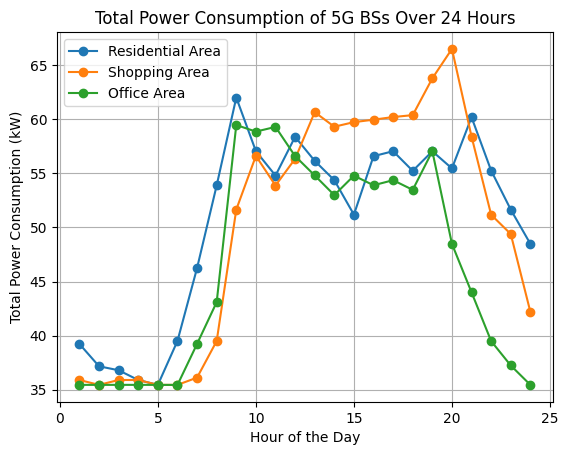

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert hex colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Define the color range for '5G Outdoors'
lower_color = hex_to_rgb('8079E4')  # Lower bound of '5G Outdoors'
upper_color = hex_to_rgb('877FE9')  # Upper bound of '5G Outdoors'

# Load the heatmap image
heatmap_image = cv2.imread('lakemba.png')  # Example image for Lakemba (residential area)
heatmap_image = cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB)

# Create a mask for the '5G Outdoors' color range
lower = np.array(lower_color, dtype="uint8")
upper = np.array(upper_color, dtype="uint8")
mask = cv2.inRange(heatmap_image, lower, upper)

# Count the number of pixels that match the '5G Outdoors' color range
aggregation_count = cv2.countNonZero(mask)

# Normalize aggregation levels to calculate lambda_beta_k_t
total_pixels = heatmap_image.shape[0] * heatmap_image.shape[1]
lambda_beta_k_t = (aggregation_count / total_pixels) * 100  # Scale to a typical value

print(f"Lambda_beta_k_t value based on the '5G Outdoors' heatmap region: {lambda_beta_k_t:.2f}")

# Constants (Example values, replace with actual data)
Nk = 10  # Number of 5G BSs in the area
Tdd_max = 1000  # Maximum downlink data rate [Mbps]
Rds_max = 500  # Maximum signaling REs [RE/s]
Pmax_AAU = 5  # Maximum power consumption of AAU [kW]
Pb_AAU = 2  # Baseline power consumption of AAU [kW]
Pb_BBU = 1  # Baseline power consumption of BBU [kW]
Pac_pe = 0.5  # Power consumption of air conditioning and power equipment per BS [kW]
ARE = 1  # Average amount of downlink data carried per RE [Mbps/RE]
Nm = 1000  # Number of Monte Carlo samples

# Activated terminals data for residential, shopping, and office areas
activated_terminals = {
    "time": np.arange(1, 25),
    "residential": [470, 240, 200, 100, 50, 500, 1250, 2100, 3000, 2450, 2200, 2600, 2350, 2150, 1800, 2400, 2450, 2250, 2450, 2275, 2800, 2250, 1850, 1500],
    "shopping": [100, 50, 100, 100, 50, 50, 125, 500, 1850, 2400, 2100, 2370, 2850, 2700, 2750, 2775, 2800, 2820, 3200, 3500, 2600, 1800, 1600, 800],
    "office": [50, 50, 50, 50, 50, 50, 470, 900, 2720, 2650, 2700, 2400, 2200, 2000, 2200, 2100, 2150, 2050, 2450, 1500, 1000, 500, 250, 50]
}

# Normal/Heavy use state for residential, shopping, and office areas
use_state = {
    "time": np.arange(1, 25),
    "residential": ['h', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
    "shopping": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n'],
    "office": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'n']
}

# Define bandwidth requirements for different services
bandwidth_requirements = {
    "non_video": 1,
    "video_8k": 60,
    "ar_vr_2d_12k": 100,
    "ar_vr_3d_8k": 135
}

# Monte Carlo Simulation for each area using exact number of terminals
def monte_carlo_simulation(area, use_state, activated_terminals, num_samples=1000):
    hours = np.arange(1, 25)
    P_S_total_k = np.zeros_like(hours, dtype=float)

    for t in hours:
        # Get the exact number of activated terminals for this hour
        expected_terminals = activated_terminals[area][t - 1]

        # Step 1: Generate hourly activated terminals based on Poisson distribution
        beta_k_t_samples = np.random.poisson(expected_terminals, num_samples)

        # Initialize accumulators for Monte Carlo simulation
        Tdd_k_t_sum = 0
        Rds_k_t_sum = 0

        for beta_k_t in beta_k_t_samples:
            # Step 2: Calculate total downlink data rate and signaling REs for each sample
            Tdd_k_t = min(Nk * Tdd_max, beta_k_t * ARE)
            Rds_k_t = min(Nk * Rds_max, Tdd_k_t / ARE)

            # Accumulate values
            Tdd_k_t_sum += Tdd_k_t
            Rds_k_t_sum += Rds_k_t

        # Average the accumulated values over all Monte Carlo samples
        Tdd_k_t_avg = Tdd_k_t_sum / num_samples
        Rds_k_t_avg = Rds_k_t_sum / num_samples

        # Step 3: Calculate incremental power consumption of AAU
        Pidd_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Tdd_max * (Tdd_k_t_avg / Nk)
        Pids_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Rds_max * (Rds_k_t_avg / Nk)

        # Step 4: Calculate total power consumption for AAU
        Pi_AAU_k_t = Pidd_AAU_k_t + Pids_AAU_k_t

        # Step 5: Calculate total power consumption of 5G BS in area k
        Pwe_k_t = Pi_AAU_k_t + Nk * Pb_AAU + Nk * Pb_BBU

        # Step 6: Calculate final total power consumption including air conditioning and power equipment
        P_S_total_k[t - 1] = Pwe_k_t + Nk * Pac_pe

    # Output the total power consumption per hour with standard formatting
    for t, P in zip(hours, P_S_total_k):
        print(f"Hour {t}: Total Power Consumption = {P:.2f} kW for {area}")

    return hours, P_S_total_k

# Run the simulation for residential, shopping, and office areas
areas = ['residential', 'shopping', 'office']

for area in areas:
    hours, P_S_total_k = monte_carlo_simulation(area, use_state, activated_terminals)

    # Plotting with formatted y-axis labels and comparison
    plt.plot(hours, P_S_total_k, marker='o', label=f'{area.capitalize()} Area')

plt.title("Total Power Consumption of 5G BSs Over 24 Hours")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)
plt.legend()
plt.show()

Lambda_beta_k_t value for lakemba.png: 22.87
Lambda_beta_k_t value for lakemba.png: 22.87
Lambda_beta_k_t value for lakemba.png: 22.87
Hour 1: Total Power Consumption = 39.24 kW for residential
Hour 2: Total Power Consumption = 37.16 kW for residential
Hour 3: Total Power Consumption = 36.80 kW for residential
Hour 4: Total Power Consumption = 35.90 kW for residential
Hour 5: Total Power Consumption = 35.45 kW for residential
Hour 6: Total Power Consumption = 39.51 kW for residential
Hour 7: Total Power Consumption = 46.24 kW for residential
Hour 8: Total Power Consumption = 53.91 kW for residential
Hour 9: Total Power Consumption = 61.98 kW for residential
Hour 10: Total Power Consumption = 57.05 kW for residential
Hour 11: Total Power Consumption = 54.80 kW for residential
Hour 12: Total Power Consumption = 58.41 kW for residential
Hour 13: Total Power Consumption = 56.15 kW for residential
Hour 14: Total Power Consumption = 54.36 kW for residential
Hour 15: Total Power Consumption =

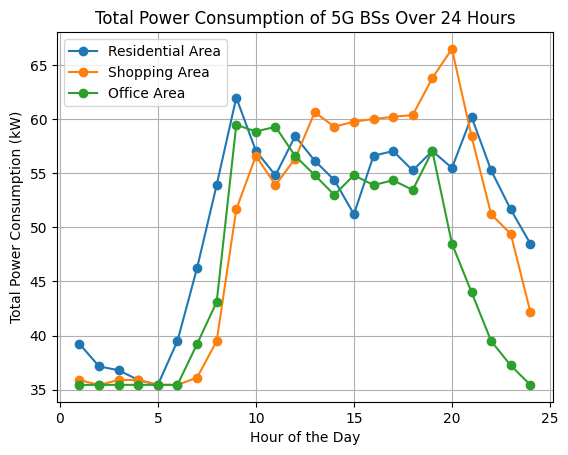

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert hex colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Load and process heatmap to calculate lambda_beta_k_t for a specific area
def process_heatmap(image_path, lower_hex_color, upper_hex_color):
    lower_color = hex_to_rgb(lower_hex_color)  # Lower bound color
    upper_color = hex_to_rgb(upper_hex_color)  # Upper bound color

    # Load the heatmap image
    heatmap_image = cv2.imread(image_path)
    heatmap_image = cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB)

    # Create a mask for the color range
    lower = np.array(lower_color, dtype="uint8")
    upper = np.array(upper_color, dtype="uint8")
    mask = cv2.inRange(heatmap_image, lower, upper)

    # Count the number of pixels that match the color range
    aggregation_count = cv2.countNonZero(mask)

    # Normalize aggregation levels to calculate lambda_beta_k_t
    total_pixels = heatmap_image.shape[0] * heatmap_image.shape[1]
    lambda_beta_k_t = (aggregation_count / total_pixels) * 100  # Scale to a typical value

    print(f"Lambda_beta_k_t value for {image_path}: {lambda_beta_k_t:.2f}")
    return lambda_beta_k_t

# Load heatmaps for different areas and calculate lambda_beta_k_t
lambda_residential = process_heatmap('lakemba.png', '8079E4', '877FE9')  # Residential heatmap
lambda_shopping = process_heatmap('lakemba.png', '8079E4', '877FE9')  # Shopping heatmap (when provided)
lambda_office = process_heatmap('lakemba.png', '8079E4', '877FE9')  # Office heatmap (when provided)

# Constants (Example values, replace with actual data)
Nk = 10  # Number of 5G BSs in the area
Tdd_max = 1000  # Maximum downlink data rate [Mbps]
Rds_max = 500  # Maximum signaling REs [RE/s]
Pmax_AAU = 5  # Maximum power consumption of AAU [kW]
Pb_AAU = 2  # Baseline power consumption of AAU [kW]
Pb_BBU = 1  # Baseline power consumption of BBU [kW]
Pac_pe = 0.5  # Power consumption of air conditioning and power equipment per BS [kW]
ARE = 1  # Average amount of downlink data carried per RE [Mbps/RE]
Nm = 1000  # Number of Monte Carlo samples

# Activated terminals data for residential, shopping, and office areas
activated_terminals = {
    "time": np.arange(1, 25),
    "residential": [470, 240, 200, 100, 50, 500, 1250, 2100, 3000, 2450, 2200, 2600, 2350, 2150, 1800, 2400, 2450, 2250, 2450, 2275, 2800, 2250, 1850, 1500],
    "shopping": [100, 50, 100, 100, 50, 50, 125, 500, 1850, 2400, 2100, 2370, 2850, 2700, 2750, 2775, 2800, 2820, 3200, 3500, 2600, 1800, 1600, 800],
    "office": [50, 50, 50, 50, 50, 50, 470, 900, 2720, 2650, 2700, 2400, 2200, 2000, 2200, 2100, 2150, 2050, 2450, 1500, 1000, 500, 250, 50]
}

# Normal/Heavy use state for residential, shopping, and office areas
use_state = {
    "time": np.arange(1, 25),
    "residential": ['h', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
    "shopping": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n'],
    "office": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'n']
}

# Monte Carlo Simulation for each area using heatmap-based lambda_beta_k_t
def monte_carlo_simulation(area, lambda_beta_k_t, use_state, activated_terminals, num_samples=1000):
    hours = np.arange(1, 25)
    P_S_total_k = np.zeros_like(hours, dtype=float)

    for t in hours:
        # Get the exact number of activated terminals for this hour
        expected_terminals = activated_terminals[area][t - 1]

        # Step 1: Generate hourly activated terminals based on Poisson distribution
        beta_k_t_samples = np.random.poisson(expected_terminals, num_samples)

        # Initialize accumulators for Monte Carlo simulation
        Tdd_k_t_sum = 0
        Rds_k_t_sum = 0

        for beta_k_t in beta_k_t_samples:
            # Step 2: Calculate total downlink data rate and signaling REs for each sample
            Tdd_k_t = min(Nk * Tdd_max, beta_k_t * ARE)
            Rds_k_t = min(Nk * Rds_max, Tdd_k_t / ARE)

            # Accumulate values
            Tdd_k_t_sum += Tdd_k_t
            Rds_k_t_sum += Rds_k_t

        # Average the accumulated values over all Monte Carlo samples
        Tdd_k_t_avg = Tdd_k_t_sum / num_samples
        Rds_k_t_avg = Rds_k_t_sum / num_samples

        # Step 3: Calculate incremental power consumption of AAU
        Pidd_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Tdd_max * (Tdd_k_t_avg / Nk)
        Pids_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Rds_max * (Rds_k_t_avg / Nk)

        # Step 4: Calculate total power consumption for AAU
        Pi_AAU_k_t = Pidd_AAU_k_t + Pids_AAU_k_t

        # Step 5: Calculate total power consumption of 5G BS in area k
        Pwe_k_t = Pi_AAU_k_t + Nk * Pb_AAU + Nk * Pb_BBU

        # Step 6: Calculate final total power consumption including air conditioning and power equipment
        P_S_total_k[t - 1] = Pwe_k_t + Nk * Pac_pe

    # Output the total power consumption per hour with standard formatting
    for t, P in zip(hours, P_S_total_k):
        print(f"Hour {t}: Total Power Consumption = {P:.2f} kW for {area}")

    return hours, P_S_total_k

# Run the simulation for residential, shopping, and office areas
lambda_values = {
    "residential": lambda_residential,
    "shopping": lambda_shopping,
    "office": lambda_office
}

areas = ['residential', 'shopping', 'office']

for area in areas:
    hours, P_S_total_k = monte_carlo_simulation(area, lambda_values[area], use_state, activated_terminals)

    # Plotting with formatted y-axis labels and comparison
    plt.plot(hours, P_S_total_k, marker='o', label=f'{area.capitalize()} Area')

plt.title("Total Power Consumption of 5G BSs Over 24 Hours")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)
plt.legend()
plt.show()

Hour 1: Total Power Consumption = 39.24 kW for residential
Hour 2: Total Power Consumption = 37.15 kW for residential
Hour 3: Total Power Consumption = 36.79 kW for residential
Hour 4: Total Power Consumption = 35.90 kW for residential
Hour 5: Total Power Consumption = 35.45 kW for residential
Hour 6: Total Power Consumption = 39.50 kW for residential
Hour 7: Total Power Consumption = 46.24 kW for residential
Hour 8: Total Power Consumption = 53.88 kW for residential
Hour 9: Total Power Consumption = 61.99 kW for residential
Hour 10: Total Power Consumption = 57.04 kW for residential
Hour 11: Total Power Consumption = 54.79 kW for residential
Hour 12: Total Power Consumption = 58.38 kW for residential
Hour 13: Total Power Consumption = 56.15 kW for residential
Hour 14: Total Power Consumption = 54.35 kW for residential
Hour 15: Total Power Consumption = 51.20 kW for residential
Hour 16: Total Power Consumption = 56.62 kW for residential
Hour 17: Total Power Consumption = 57.07 kW for r

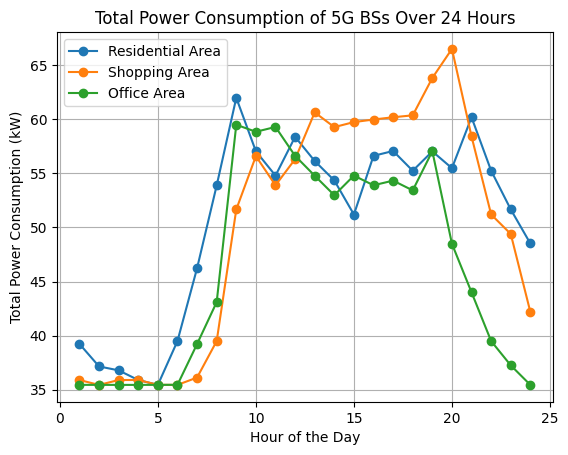

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants (replace with actual values)
Nk = 10  # Number of 5G BSs in the area
Tdd_max = 1000  # Maximum downlink data rate [Mbps]
Rds_max = 500  # Maximum signaling REs [RE/s]
Pmax_AAU = 5  # Maximum power consumption of AAU [kW]
Pb_AAU = 2  # Baseline power consumption of AAU [kW]
Pb_BBU = 1  # Baseline power consumption of BBU [kW]
Pac_pe = 0.5  # Power consumption of air conditioning and power equipment per BS [kW]
ARE = 1  # Average amount of downlink data carried per RE [Mbps/RE]
Nm = 1000  # Number of Monte Carlo samples

# Activated terminals data for residential, shopping, and office areas
activated_terminals = {
    "time": np.arange(1, 25),
    "residential": [470, 240, 200, 100, 50, 500, 1250, 2100, 3000, 2450, 2200, 2600, 2350, 2150, 1800, 2400, 2450, 2250, 2450, 2275, 2800, 2250, 1850, 1500],
    "shopping": [100, 50, 100, 100, 50, 50, 125, 500, 1850, 2400, 2100, 2370, 2850, 2700, 2750, 2775, 2800, 2820, 3200, 3500, 2600, 1800, 1600, 800],
    "office": [50, 50, 50, 50, 50, 50, 470, 900, 2720, 2650, 2700, 2400, 2200, 2000, 2200, 2100, 2150, 2050, 2450, 1500, 1000, 500, 250, 50]
}

# Normal/Heavy use state for residential, shopping, and office areas
use_state = {
    "time": np.arange(1, 25),
    "residential": ['h', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
    "shopping": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n'],
    "office": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'n']
}

# Monte Carlo Simulation for each area
def monte_carlo_simulation(area, use_state, activated_terminals, num_samples=1000):
    hours = np.arange(1, 25)
    P_S_total_k = np.zeros_like(hours, dtype=float)

    for t in hours:
        # Get the exact number of activated terminals for this hour
        expected_terminals = activated_terminals[area][t - 1]

        # Step 1: Generate hourly activated terminals based on Poisson distribution
        beta_k_t_samples = np.random.poisson(expected_terminals, num_samples)

        # Initialize accumulators for Monte Carlo simulation
        Tdd_k_t_sum = 0
        Rds_k_t_sum = 0

        for beta_k_t in beta_k_t_samples:
            # Step 2: Calculate total downlink data rate and signaling REs for each sample
            Tdd_k_t = min(Nk * Tdd_max, beta_k_t * ARE)  # Eq. 12
            Rds_k_t = min(Nk * Rds_max, Tdd_k_t / ARE)   # Eq. 11

            # Accumulate values
            Tdd_k_t_sum += Tdd_k_t
            Rds_k_t_sum += Rds_k_t

        # Average the accumulated values over all Monte Carlo samples
        Tdd_k_t_avg = Tdd_k_t_sum / num_samples
        Rds_k_t_avg = Rds_k_t_sum / num_samples

        # Step 3: Calculate incremental power consumption of AAU (Eq. 13, Eq. 14)
        Pidd_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Tdd_max * (Tdd_k_t_avg / Nk)  # Eq. 13
        Pids_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Rds_max * (Rds_k_t_avg / Nk)  # Eq. 14

        # Step 4: Calculate total power consumption for AAU (Eq. 17)
        Pi_AAU_k_t = Pidd_AAU_k_t + Pids_AAU_k_t  # Eq. 2

        # Step 5: Calculate total power consumption of 5G BS in area k (Eq. 18)
        Pwe_k_t = Pi_AAU_k_t + Nk * Pb_AAU + Nk * Pb_BBU  # Eq. 1

        # Step 6: Calculate final total power consumption including air conditioning and power equipment (Eq. 19)
        P_S_total_k[t - 1] = Pwe_k_t + Nk * Pac_pe

    # Output the total power consumption per hour with standard formatting
    for t, P in zip(hours, P_S_total_k):
        print(f"Hour {t}: Total Power Consumption = {P:.2f} kW for {area}")

    return hours, P_S_total_k

# Run the simulation for residential, shopping, and office areas
areas = ['residential', 'shopping', 'office']

for area in areas:
    hours, P_S_total_k = monte_carlo_simulation(area, use_state, activated_terminals)

    # Plotting with formatted y-axis labels and comparison
    plt.plot(hours, P_S_total_k, marker='o', label=f'{area.capitalize()} Area')

plt.title("Total Power Consumption of 5G BSs Over 24 Hours")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)
plt.legend()
plt.show()